## Prototype LABELATOR with anndata pytorch loader

### overview.
This notebook protypes a "labelator".  The purpose of a "labelator" is to easily classify _cell types_ for out-of-sample "Test" data. 

Currently we are prototyping with several `anndata` _dataloaders_.  `scvi-tools`, `scarches`, and `anndata` each have an implimenation of a `torch` _dataloader_.   The `scarches` flavor seems to be a good middle ground and then DO have an SCVI implimentation.    Probably will use the _native_ loader for each type, but an `scarches` variant for our simpler models. 

To state our confirmation bias, it impliments the SCVI models which we like.

We will validate potential models and calibrate them with simple expectations using a typical "Train"/"Validate" and "Test"/"Probe" approach.  


Definitions:
- "Train": data samples on which the model being tested is trained.  The `torch lightning` framework used by `scvi-tools` semi-automatically will "validate" to test out-of-sample prediction fidelity during training.
- "Test": held-out samples to test the fidelity of the model.  
- "Probe": data generated externally,which is _probing_ the fidelity of the model to general scRNAseq data.

-----------------
### Data:
All models will be trained on the n=3000 most highly variable genes from Xylena's scRNAseq data.  `scVI` parameters are enumerated below.

```python 
continuous_covariate_keys = None #noise = ['doublet_score', 'percent.mt', 'percent.rb'] # aka "noise"
layer = "counts"
batch = "sample" #'batch'
categorical_covariate_keys = None #['sample', 'batch'] Currently limited to single categorical...
labels = 'cell_type'
size_factor_key = None # library size 
```
----------------
### Models:
Our general approach will be to "compress" the raw count data, and generate probability of each label category.  We will do this in two ways: 

1) **naive** mode.  Or making no assumptions or attempts to account for confounding variables like "batch", "noise" (e.g. doublets, mt/rb contamination), or "library_size".   

2) **transfer** mode.  i.e. `scarches` or `scvi-tools`.  Basically, we will need to _fit_ these confounding variables for the out-of-sample data using the `scarches` _surgery_ approach.


We'll can do this in either a single **end-to-end** way or in two steps. 

#### 2 step: encode + categorize
In two steps:
1) _encode_: embedding the scRNAseq counts into a latent sub-space
    - VAE (e.g. MMD-VAE, infoVAE etc)
    - PCA (_naive_ linear encoding)
    - scVI-latent (__naive__ VAE)
    - etc.
    - scVI (__transfer__ VAE)

2) _categorize_: predicting creating a probability of a each category 
    - Linear classifier (e.g. multinomial Logistic Regression)
    - NN non-linear classifier 
    - boosted trees (XGboost)

We will use a variety of models to "embed" the scRNAseq counts into lower dimension.
- scVI latents

#### end-to-end
We will also try some _end-to-end_ approaches for comparision.  In these models a single model takes us from raw counts to category probabilities.
- __naive__ inference
    - boosted trees (e.g. xgboost)
    - VAE + classifier

- __transfer__ learning
    - scANVI scarches "surgery"


----------------
### training & validation
Models will be trained on the "train" set from xylena's "clean" data.   Validation on a subset of the training data will ensure that overfitting is not a problem.  

Extending the `scarches` models and training classes seems to be the most straightforward.  The `scvi-tools` employs `ligntening` which _may_ be good to leverage eventually, but is overbuilt for the current state.

- scVI
    - batch/sample/depth params vs. neutered
- scANVI
    - 


- _naive_ batch correction
- fit a model with a latent "batch" from the 


>scVI: encoder, latent_i, latent_batch_i, latent_library_i, (x_hat = vae(x))

>scANVI: encoder, latent_i, latent_batch_i, latent_library_i, (x_hat = vae(x))


----------------
### inference :: _testing_ :: _probing_
Two types of "inference" modes will be considered.  
1) batch corrected (scVI/scANVI) which requires transfer learning on the probe data
2) naive, which simply processes the examples

------------
### metrics
- pct accuracy  
- ?




## Caveats
There are several gotchas to anticipate:
- features.  Currently we are locked into the 3k genes we are testing with.  Handling subsets and supersets is TBC.
- batch.  In principle each "embedding" or decode part of the model should be able to measure a "batch-correction" parameter explicitly.  in scVI this is explicitly _learned_.  However in _naive_ inference mode it should just be an inferred fudge factor.
- noise.  including or not including `doublet`, `mito`, or `ribo` metrics




### List of models

target:  8 cell types including "unknown"  also have 

1. scVI 
    - train end-to-end for transfer learining
    - encode + classify
        - test classification directly from the scVI latent.  
        - extract the latent representation to test its fidelity at predicting.  I.e. encode cellcounts directly to scVI_latent Train class (naive to batch, noise)

2. trVAE / VAE
    - train end-to-end for transfer learning
    - encode + classify
        - test classification directly from the scVI latent.  
        - extract the latent representation to test its fidelity at predicting.  I.e. encode cellcounts directly to scVI_latent Train class (naive to batch, noise)

3. PCA Classification
    a. raw count PCA
        - directly classify from PC loadings
    b. scVI "normalized" gene expression PCA
        - directly classify from PC loadings

4. XGBoost
    a. end-to-end classificaiton


In [20]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip uninstall -y typing_extensions
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()

In [21]:

from pathlib import Path

import scanpy as sc
import torch

import matplotlib.pyplot as plt
import numpy as np
import anndata as ad

from scvi.model import SCVI

if sys.platform != "darwin":
    torch.set_float32_matmul_precision("medium")  
else:
    print("MPS backend: ",torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
    print("MPS (built): ",torch.backends.mps.is_built()) #MPS is activated

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
from lbl8r.utils import (
            make_latent_adata,
            add_predictions_to_adata,
            plot_predictions,
            plot_embedding,
            export_ouput_adata,
            make_scvi_normalized_adata,
            make_pc_loading_adata,
            
    )

from lbl8r.lbl8r import scviLBL8R
from lbl8r import ( get_lbl8r_scvi, 
                    add_lbl8r_classifier, 
                    prep_lbl8r_adata, 
                    query_lbl8r, 
                    query_scvi,
                    get_pca_lbl8r
                    )


%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:

sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Stubs to find the data

In [23]:
if IN_COLAB:
    root_path = Path("/content/drive/MyDrive/")
    data_path = root_path / "SingleCellModel/data"
else:
    root_path = Path("../")
    if sys.platform == "darwin":
        data_path = root_path / "data/xylena_raw"
    else:
        data_path = root_path / "data/scdata/xylena"
        raw_data_path = root_path / "data/scdata/xylena_raw"

XYLENA_ANNDATA = "brain_atlas_anndata.h5ad"
XYLENA_METADATA = "final_metadata.csv"
XYLENA_ANNDATA2 = "brain_atlas_anndata_updated.h5ad"

XYLENA_TRAIN = XYLENA_ANNDATA.replace(".h5ad", "_train_cnt.h5ad")
XYLENA_TEST = XYLENA_ANNDATA.replace(".h5ad", "_test_cnt.h5ad")

XYLENA_TRAIN_SPARSE = XYLENA_TRAIN.replace(".h5ad", "_sparse.h5ad")
XYLENA_TEST_SPARSE = XYLENA_TEST.replace(".h5ad", "_sparse.h5ad")

In [24]:
# # subsample 40k cells for prototyping
# subsamples = np.random.choice(train_ad.shape[0], 40_000, replace=False)
# train_ad = train_ad[subsamples,:].copy() # no copy... just alias

In [25]:
CELL_TYPE_KEY = "cell_type"
OUT_PATH = data_path / "LBL8R"

--------------

## pcaLBL8R on normalized PCAs 

To give the pca "baseline" a fair shake its important to use normalized counts.  Using the `scVI` normalization is our best shot... (Although the current models are NOT batch correcting since we don't have a good strategy to do this with probe data)

## 0. Load training data

In [26]:
filen = OUT_PATH / XYLENA_TRAIN.replace("_cnt.h5ad", "_exp_nb_out.h5ad")
train_ad = ad.read_h5ad(filen)

## model definition

Here we want to classify based on the PCA loadings.

Here we define a helper multilayer perceptron class to use it with a VAE below.

In [27]:
model_path = root_path / "lbl8r_models"
if not model_path.exists():
    model_path.mkdir()

retrain = False


## 1 setup data and load `pcaLBL8R` 

`setup_anndata` and load model.  (Or instantiate and train)


(502085, 50)
INFO     File ../lbl8r_models/LBL8R_scVIexp_pca/model.pt already downloaded                                        


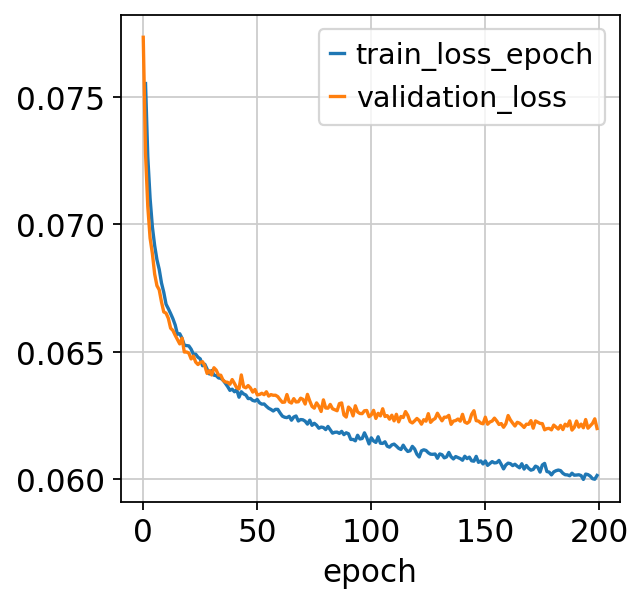

In [28]:
MODEL_NAME = "LBL8R_scVIexp_pca"

labelator, train_ad = get_pca_lbl8r(
    train_ad,
    labels_key=CELL_TYPE_KEY,
    model_path=model_path,
    retrain=retrain,
    model_name=MODEL_NAME,
    plot_training=True,
)

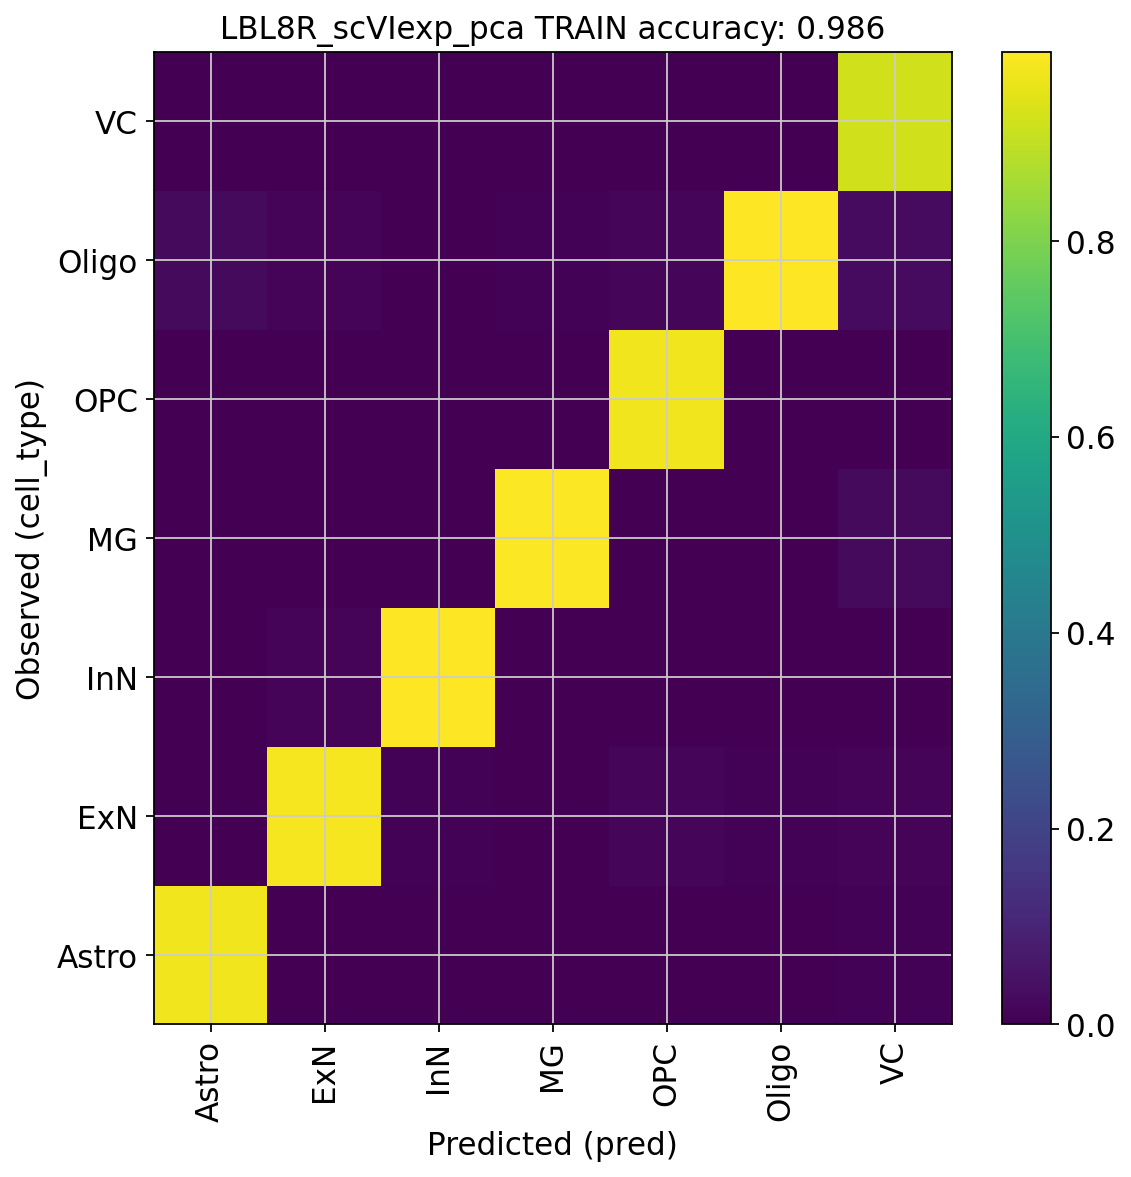

In [29]:
plot_predictions(
    train_ad,
    pred_key="pred",
    cell_type_key=CELL_TYPE_KEY,
    model_name=MODEL_NAME,
    title_str="TRAIN",
)

perfoming mde on cuda


/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


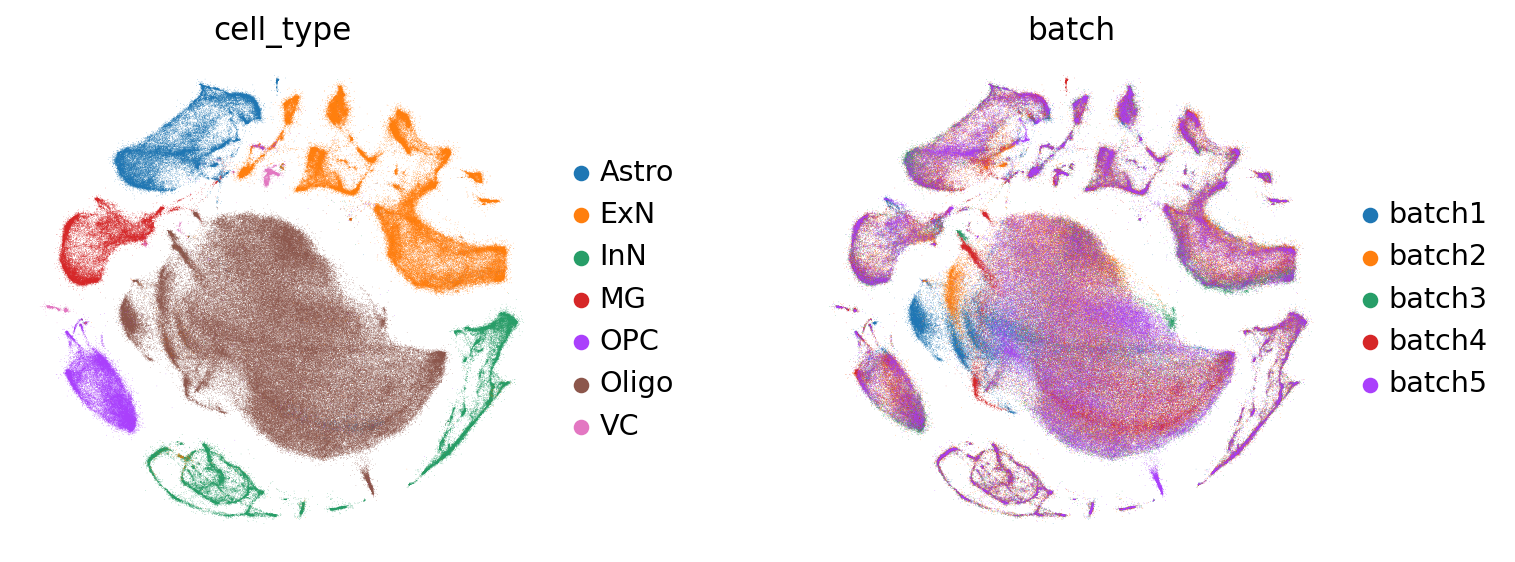

In [30]:
# this should also add the embeddings to the adata
plot_embedding(train_ad,
               basis="X_mde",
                color=[CELL_TYPE_KEY, "batch"],
                frameon=False,
                wspace=0.35,
                device="cuda")

------------------
Now TEST

In [31]:
filen = OUT_PATH / XYLENA_TEST.replace("_cnt.h5ad", "_exp_nb_out.h5ad")
test_ad = ad.read_h5ad(filen)




In [32]:
test_ad = make_pc_loading_adata(test_ad)

# 
# latent_test_ad = prep_lbl8r_adata(test_ad, vae, labels_key=CELL_TYPE_KEY)


(207726, 50)


In [33]:


test_ad = query_lbl8r(
    test_ad,
    labelator,
    labels_key=CELL_TYPE_KEY,
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


(207726, 50)


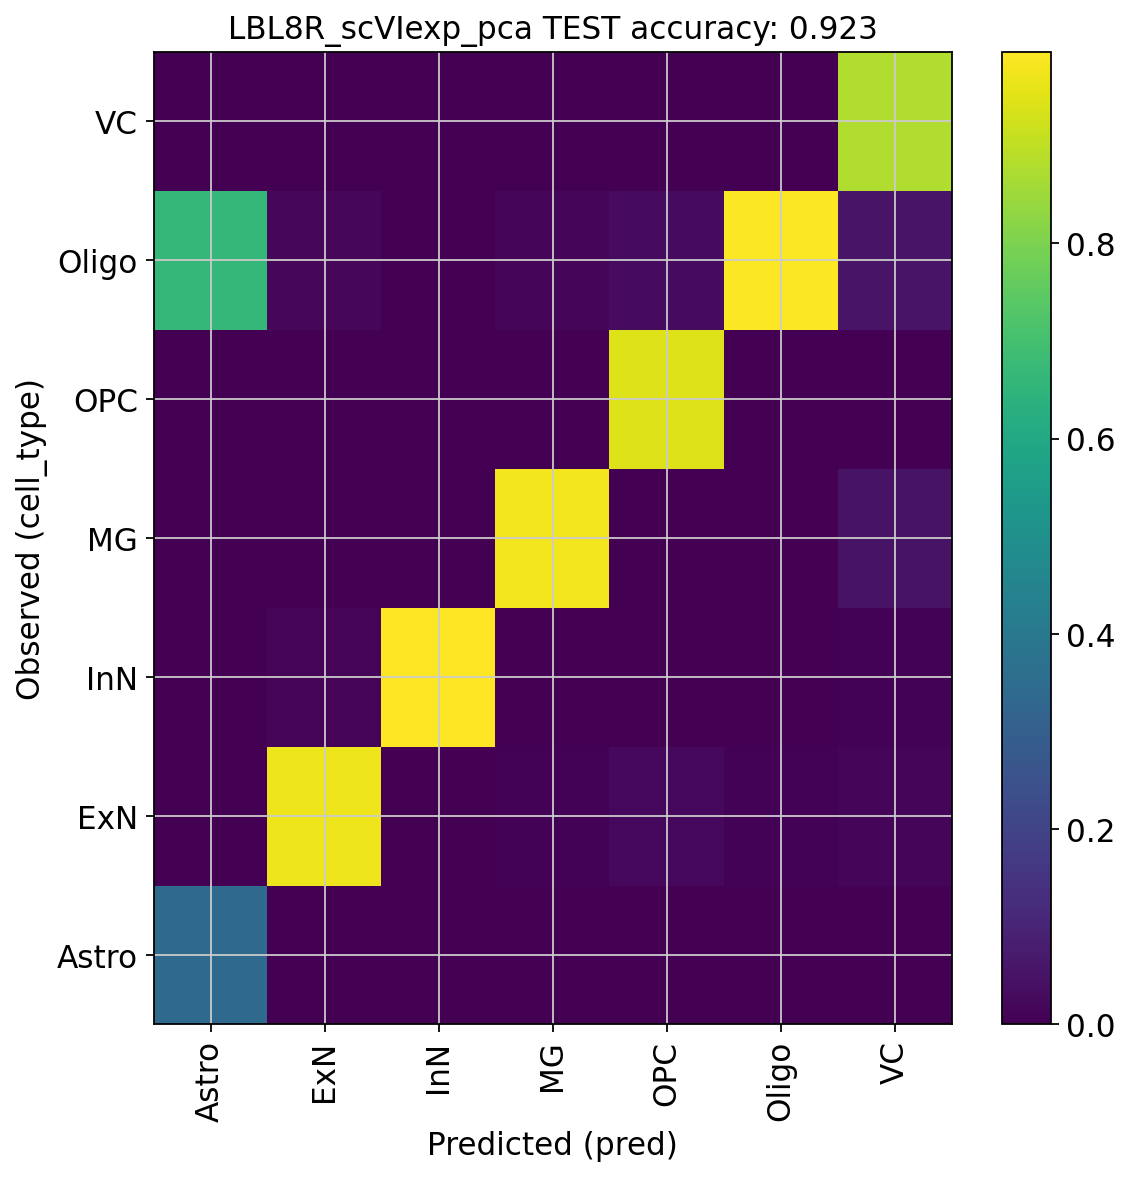

In [34]:
plot_predictions(
    test_ad,
    pred_key="pred",
    cell_type_key=CELL_TYPE_KEY,
    model_name=MODEL_NAME,
    title_str="TEST",
)

perfoming mde on cuda


/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


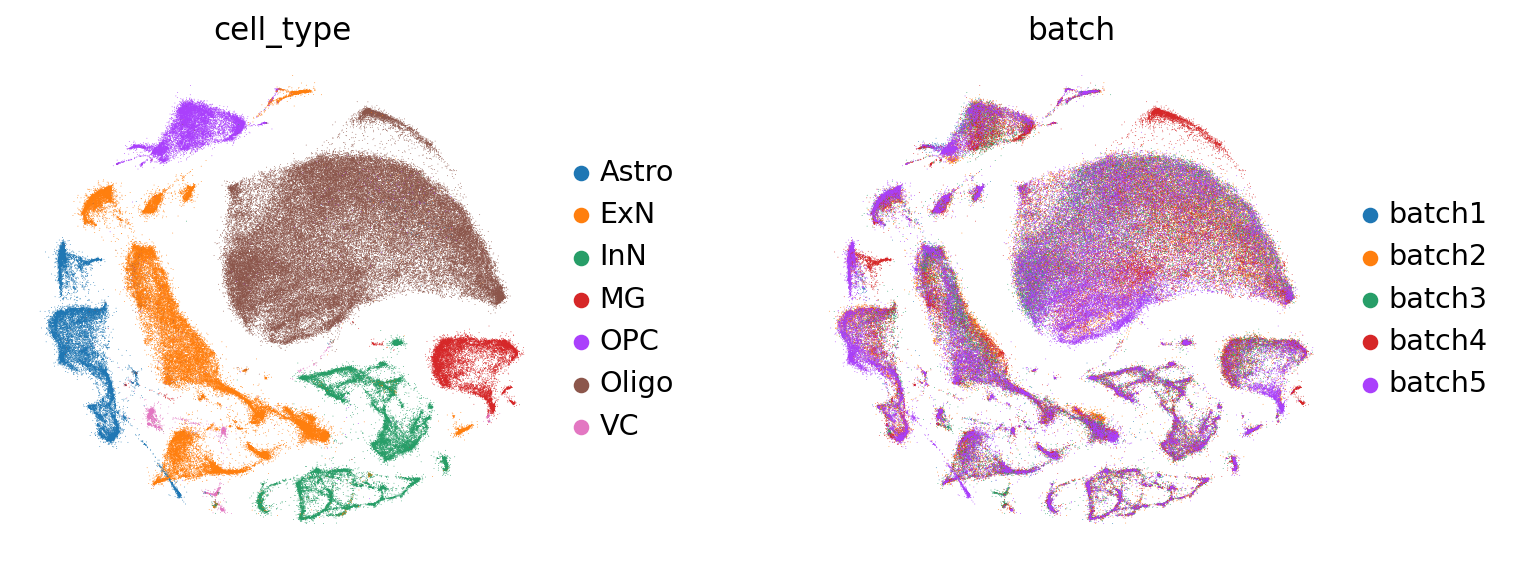

In [35]:
# this should also add the embeddings to the adata
plot_embedding(test_ad,
               basis="X_mde",
                color=[CELL_TYPE_KEY, "batch"],
                frameon=False,
                wspace=0.35,
                device="cuda")

## 7: save versions of test/train with latents and embeddings added

In [36]:
export_ouput_adata(train_ad, XYLENA_TRAIN.replace("_cnt.h5ad", "_exp_nb_pca.h5ad"), OUT_PATH)

export_ouput_adata(test_ad, XYLENA_TEST.replace("_cnt.h5ad", "_exp_nb_pca.h5ad"), OUT_PATH)


wrote: ../data/scdata/xylena/LBL8R/brain_atlas_anndata_train_exp_nb_pca_out.h5ad
wrote: ../data/scdata/xylena/LBL8R/brain_atlas_anndata_test_exp_nb_pca_out.h5ad
